# Advanced topics

## Stochastic gradient MCMC

We defined two SGLD sampler in `hebo.models.nn.sgld`: `hebo.models.nn.sgld.SGLD` and `hebo.models.nn.sgld.pSGLD`. To perform mini-batch MCMC, user should define the negative log posterior as a differentiable loss function can use the two samplers just like using `torch.optim` optimizers.

As as deomstration, we use the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) as the negative log-likelihood, to demonstrate how we can use SGLD to efficiently sample from the posterior.

$$
-\rm{log\_prob}(x,y) \propto (a - x)^2 + b \times (y - x^2)^2
$$


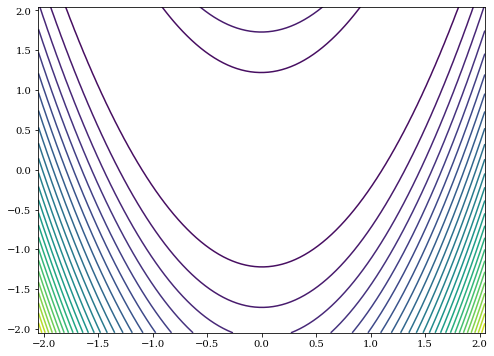

In [47]:
import numpy as np
from pymoo.factory import get_problem, get_visualization

problem = get_problem("rosenbrock", n_var=2)
get_visualization("fitness-landscape", problem, angle=(45, 45), _type="contour").show()


In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange
from hebo.models.nn.sgld import pSGLD, SGLD
from torch.distributions import Normal

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [02:05<00:00, 3973.68it/s]


Text(0.5, 1.0, 'Sample from Rosenbrock function')

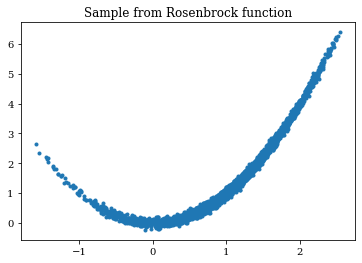

In [50]:
para = nn.Parameter(torch.randn(2))
opt  = pSGLD([para], lr = 1e-3, pretrain_step=300)
a = 1
b = 100
burn_in = 1000
step    = 100
samp    = []
for epoch in trange(500000):
    opt.zero_grad()
    x = para[0]
    y = para[1]
    obj = (a - x)**2 + b * (y - x**2)**2
    obj.backward()
    opt.step()
    if epoch > burn_in and epoch % step == 0:
        samp.append(para.detach().clone())
samp_sgld = torch.stack(samp)
plt.plot(samp_sgld[:,0], samp_sgld[:,1], '.')
plt.title('Sample from Rosenbrock function')

### Comparison between SGLD and pSGLD

We use [Neal's Funnel](https://mc-stan.org/docs/2_28/stan-users-guide/reparameterization.html) distribution to compare SGLD with pSGLD, the distribution is defined as

$$
\mathrm{p}(x,y) = \mathcal{N}(y|0,3) \times \mathcal{N}(x|0,\exp(\frac{y}{2}))
$$

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:26<00:00, 1911.01it/s]


Text(0.5, 1.0, "Real samples from Neal's Funnel")

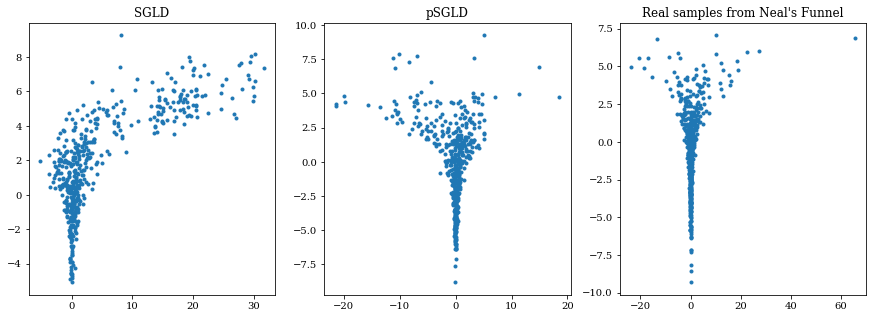

In [130]:
burn_in = 1000
step    = 100
samp    = []
para = nn.Parameter(torch.randn(2))
opt  = SGLD([para], lr = 1e-2, pretrain_step=300)
for epoch in trange(50000):
    opt.zero_grad()
    x = para[0]
    y = para[1]
    log_prob = Normal(0., 3.).log_prob(y) + Normal(0., (y/2).exp()).log_prob(x)
    obj = -1 * log_prob
    obj.backward()
    opt.step()
    if epoch > burn_in and epoch % step == 0:
        samp.append(para.detach().clone())
samp_sgld = torch.stack(samp)

samp    = []
para = nn.Parameter(torch.randn(2))
opt  = pSGLD([para], lr = 1e-2, pretrain_step=300)
for epoch in trange(50000):
    opt.zero_grad()
    x = para[0]
    y = para[1]
    log_prob = Normal(0., 3.).log_prob(y) + Normal(0., (y/2).exp()).log_prob(x)
    obj = -1 * log_prob
    obj.backward()
    opt.step()
    if epoch > burn_in and epoch % step == 0:
        samp.append(para.detach().clone())
samp_psgld = torch.stack(samp)

samp_true      = 3 * torch.randn_like(samp_psgld)
samp_true[:,0] = (samp_true[:,1] / 2).exp() * torch.randn(samp_true.shape[0])

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(samp_sgld[:,0], samp_sgld[:,1], '.')
plt.title('SGLD')

plt.subplot(1,3,2)
plt.plot(samp_psgld[:,0], samp_psgld[:,1], '.')
plt.title('pSGLD')

plt.subplot(1,3,3)
plt.plot(samp_true[:,0], samp_true[:,1],'.')
plt.title("Real samples from Neal's Funnel")

### Bayesian linear regression

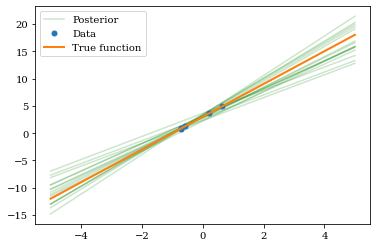

In [92]:
x_tr = 2 * torch.rand(5,1) - 1
y_tr = 3 * x_tr + 3 + 0.1 * torch.randn(5,1)
x    = torch.linspace(-5,5,100).view(-1,1)
y    = 3 * x + 3


net = nn.Linear(1,1)
opt = pSGLD(net.parameters())
crit = nn.MSELoss(reduction = 'sum')
for epoch in range(5000):
    py = net(x_tr)
    opt.zero_grad()
    loss = crit(py, y_tr)
    loss.backward()
    opt.step()
    if epoch >= 1000 and epoch % 250 == 0:
        with torch.no_grad():
            py_all = net(x)
            plt.plot(x, py_all.detach(), color = 'g', alpha = 0.2, label = 'Posterior' if epoch == 1000 else None)
plt.plot(x_tr, y_tr, '.', label = 'Data', markersize = 10)
plt.plot(x,y, linewidth=2, label = 'True function')
plt.legend()

### Bayesian nerual network wtih `hebo.models.pSGLDEnsemble`

We use the boston housing dataset to demonstrate how you can use Bayesian neural network defined in HEBO to perform probablistic regression

In [104]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from hebo.models.nn.sgld import pSGLDEnsemble

X, y  = load_boston(return_X_y = True)
y     = y.reshape(-1,1)
x_tr, x_tst, y_tr, y_tst = train_test_split(X, y, test_size = 0.2, shuffle = True)
x_tr  = torch.from_numpy(x_tr).float()
y_tr  = torch.from_numpy(y_tr).float()
x_tst = torch.from_numpy(x_tst).float()
y_tst = torch.from_numpy(y_tst).float()
model = pSGLDEnsemble(x_tr.shape[1], 0, y_tr.shape[1])
model.fit(x_tr, None, y_tr)

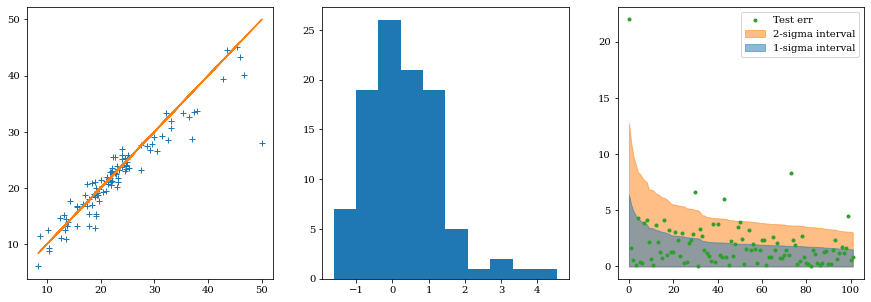

In [133]:
with torch.no_grad():
    py, ps2 = model.predict(x_tst, None)
    ps      = ps2.sqrt()
    normed  = (y_tst - py) / ps
    err     = (y_tst - py).abs()

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(y_tst, py, '+')
plt.plot(y_tst, y_tst)

plt.subplot(1,3,2)
plt.hist(normed.view(-1).numpy())

plt.subplot(1,3,3)
order = ps.view(-1).argsort().flip(dims = (0,))
plt.fill_between(torch.arange(order.numel()), 2 * ps.view(-1)[order], alpha = 0.5, color = 'C1', label = '2-sigma interval')
plt.fill_between(torch.arange(order.numel()), 1 * ps.view(-1)[order], alpha = 0.5, color = 'C0', label = '1-sigma interval')

plt.plot(err[order], '.', color = 'C2', label = 'Test err')
plt.legend()

### Reference

- [SGLD](https://www.stats.ox.ac.uk/~teh/research/compstats/WelTeh2011a.pdf)
- [pSGLD](https://arxiv.org/abs/1512.07666)

### Copyright statement

Copyright (C) 2020. Huawei Technologies Co., Ltd. All rights reserved.

This program is free software; you can redistribute it and/or modify it under
the terms of the MIT license.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the MIT License for more details.
Configuration file for the Sphinx documentation builder.
